In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import os.path as op
import sys

import numpy as np
import pandas as pd
import xarray as xr

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
import matplotlib
import cartopy.crs as ccrs

# Principal component analysis and kmeans libs
from sklearn.decomposition import PCA

# PCA

## x=y

In [3]:
x = np.linspace(2, 4, 100)
y = x

In [4]:
matrix_pca = np.vstack([x, y]).T
matrix_pca.shape #[Number of points] x [Number of dimensions]

(100, 2)

In [5]:
#Principal Component Analysis
pca = PCA(n_components=np.shape(matrix_pca)[1]).fit(matrix_pca)

[0.4857857 0.4857857]


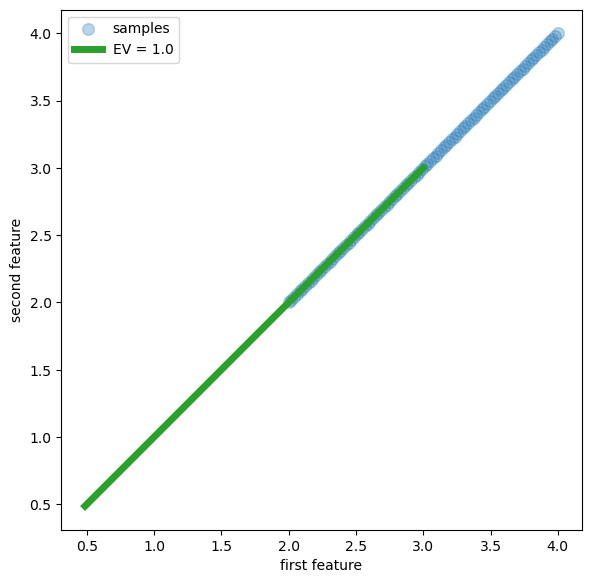

In [6]:
fig = plt.figure(figsize = [6, 6], tight_layout=True)
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0,0])

ax.scatter(matrix_pca[:, 0], matrix_pca[:, 1], s=70, alpha=0.3, label="samples")

for n in range(1):
    
    comp = pca.components_[n] * pca.explained_variance_[n]
    
    plt.plot([np.mean(matrix_pca[:,0]), comp[0]],
        [np.mean(matrix_pca[:,0]), comp[1]],
        label= 'EV = {0}'.format(np.round(pca.explained_variance_ratio_[n],2)),
        linewidth=5,
        color=f"C{n + 2}"
    )
    
    print(comp)
    
ax.set(
    aspect="equal",
    xlabel="first feature",
    ylabel="second feature",
)

plt.legend()

## 2D variability

In [7]:
#Create a random matrix with correlation between the different variables

rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 3], [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)

In [8]:
#Principal Component Analysis
pca = PCA(n_components=np.shape(X)[1]).fit(X)

[-4.00088641 -4.75249258]
[ 0.35146166 -0.29587804]


[None,
 Text(0.5, 1.0, '2-dimensional dataset with principal components'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y')]

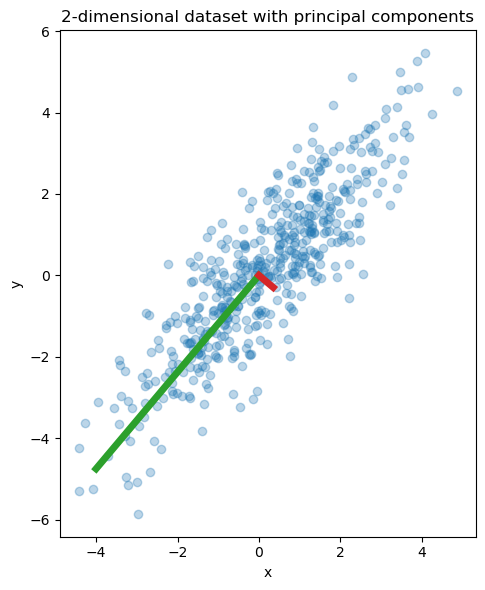

In [9]:
fig = plt.figure(figsize = [6, 6], tight_layout=True)
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0,0])

ax.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")


for n in range(pca.n_components):
    
    comp = pca.components_[n] * pca.explained_variance_[n]
    
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {n}",
        linewidth=5,
        color=f"C{n + 2}",
    )
    
    print(comp)
    
ax.set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="x",
    ylabel="y",
)

## Real Data

In [10]:
from scipy.io import loadmat


p_db = op.join(os.getcwd(),'..','..','data','extra')

# database waves (mat file)
p_dat = op.join(p_db, 'shoreline.mat')

# database exploration
data_mat = loadmat(p_dat)

data_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SLA', 'lat', 'lon'])

In [11]:
sla = data_mat['SLA'] #Points x Times
lat = data_mat['lat'][0] #Points
lon = data_mat['lon'][0] #Points

In [12]:
s= np.unique(np.where(lon<160)[0])
sla = sla[s,:]
lat = lat[s]
lon = lon[s]

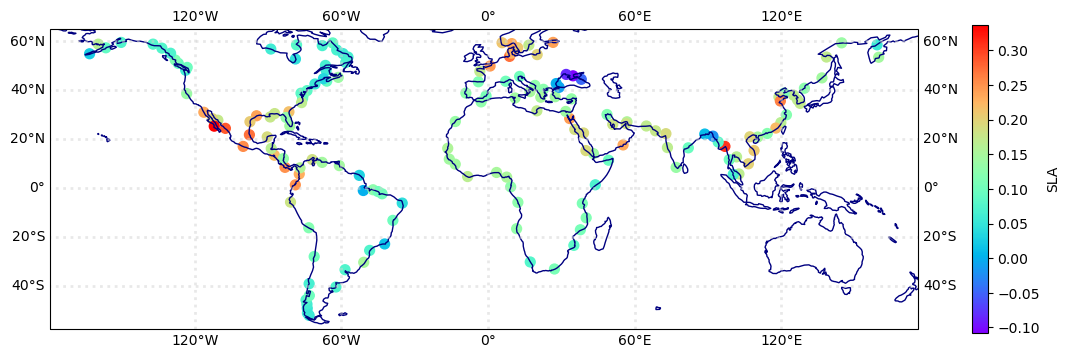

In [13]:
time = 190 #position of time to plot

plt.figure(figsize=(14, 4))    
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax.coastlines(zorder=2, color = 'navy');
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='lightgrey', linestyle=':',  alpha=.5)

im = ax.scatter(lon, lat, s=50, c = sla[:,time], transform = ccrs.PlateCarree(), cmap = 'rainbow')

plt.colorbar(im).set_label('SLA')


In [14]:
matrix_pca = sla.T
matrix_pca.shape

(192, 171)

In [15]:
# standarize predictor
pred_mean = np.mean(matrix_pca, axis=0)
pred_std = np.std(matrix_pca, axis=0)
matrix_pca_norm = (matrix_pca[:,:] - pred_mean) / pred_std
matrix_pca_norm[np.isnan(matrix_pca_norm)] = 0

In [16]:
n_components = 100 #np.min(matrix_pca.shape))
pca = PCA(n_components=n_components)

In [17]:
pca.fit(matrix_pca_norm)

PCA(n_components=100)

In [18]:
PCs = pca.transform(matrix_pca_norm)

In [19]:
xds_PCA = xr.Dataset(
    {
        'PCs': (('time', 'n_components'), PCs),
        'EOFs': (('points','n_components'), pca.components_.T),#*np.sqrt(pca.explained_variance_)),
        'variance': (('n_components',), pca.explained_variance_),
        'means': (('points',), pred_mean),
        'stds': (('points',), pred_std),
        'time': (('time'), range(sla.shape[1]))
    }
)

Number of PCs explaining 99% of the variance = 91


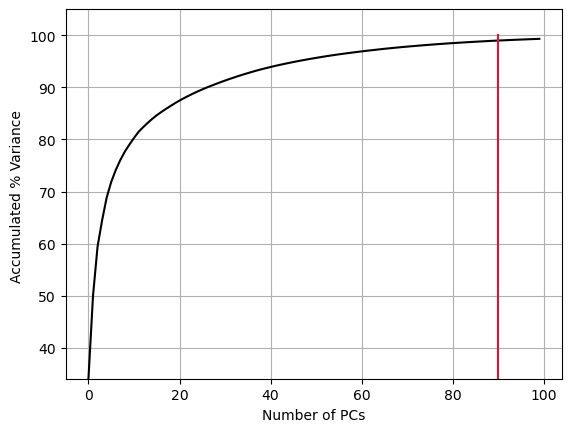

In [20]:
n_perc = 99

s= np.where(np.cumsum(pca.explained_variance_ratio_*100)>n_perc)[0]

n_pcs = s[0]

print('Number of PCs explaining {0}% of the variance = {1}'.format(n_perc, n_pcs))
plt.plot(np.cumsum(pca.explained_variance_ratio_*100), color = 'black')
plt.plot([s[0]-1, s[0]-1], [pca.explained_variance_ratio_[0]*100,100], color = 'crimson')

plt.xlabel('Number of PCs')
plt.ylabel('Accumulated % Variance ')
plt.ylim(pca.explained_variance_ratio_[0]*100, 105)
plt.grid()


Text(0, 0.5, 'PC0')

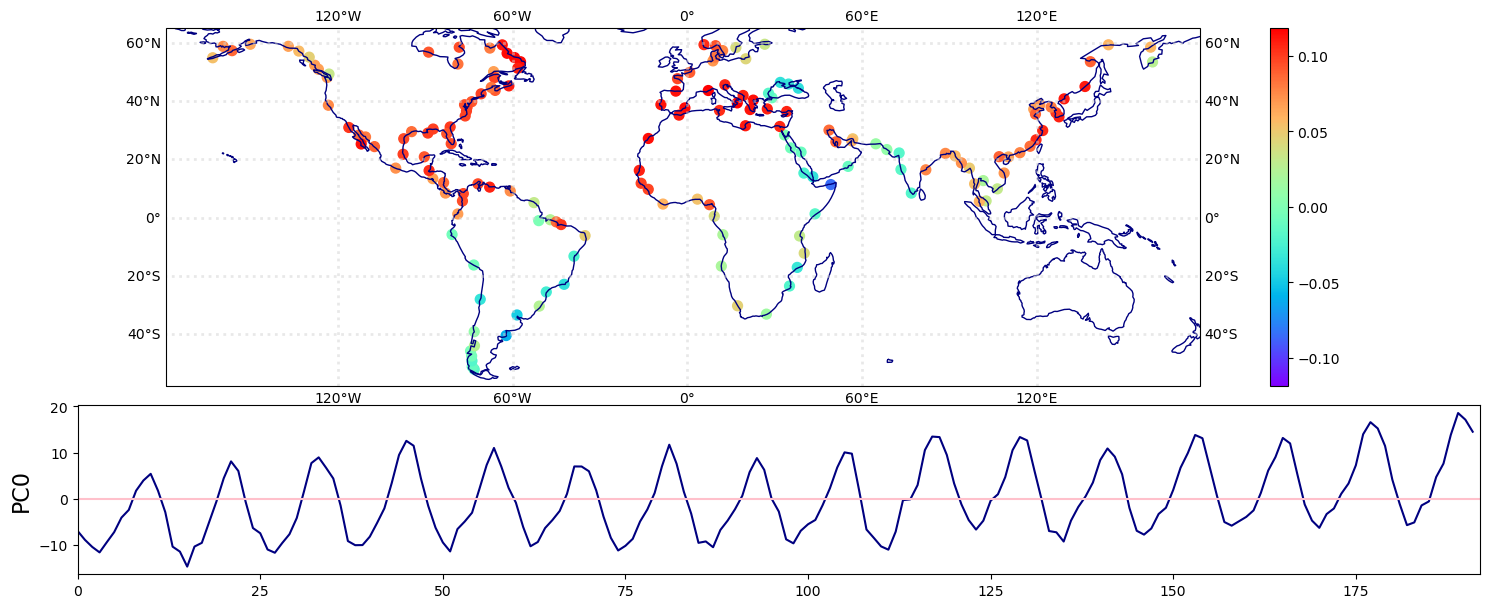

In [21]:
pc_plot = 0

fig = plt.figure(figsize = [15, 6], tight_layout=True)
gs = gridspec.GridSpec(3, 1)
ax = fig.add_subplot(gs[:2,0], projection=ccrs.PlateCarree() )

ax.coastlines(zorder=2, color = 'navy');
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='lightgrey', linestyle=':',  alpha=.5)

lim = np.max([np.abs(np.min(xds_PCA.isel(n_components = pc_plot).EOFs.values)), np.max(xds_PCA.isel(n_components = pc_plot).EOFs.values)])

im = ax.scatter(lon, lat, s=50, c = xds_PCA.isel(n_components = pc_plot).EOFs.values,
                transform = ccrs.PlateCarree(), vmin=-lim, vmax= lim, cmap = 'rainbow')

plt.colorbar(im, ax=ax)


ax1 = fig.add_subplot(gs[2,0])
ax1.plot(xds_PCA.isel(n_components = pc_plot).PCs.values, color = 'navy')
ax1.plot([0, len(xds_PCA.time)], [0,0], color = 'pink')
ax1.set_xlim([0, len(xds_PCA.time)])
ax1.set_ylabel('PC{0}'.format(pc_plot), fontsize = 16)


Text(0, 0.5, 'PC1')

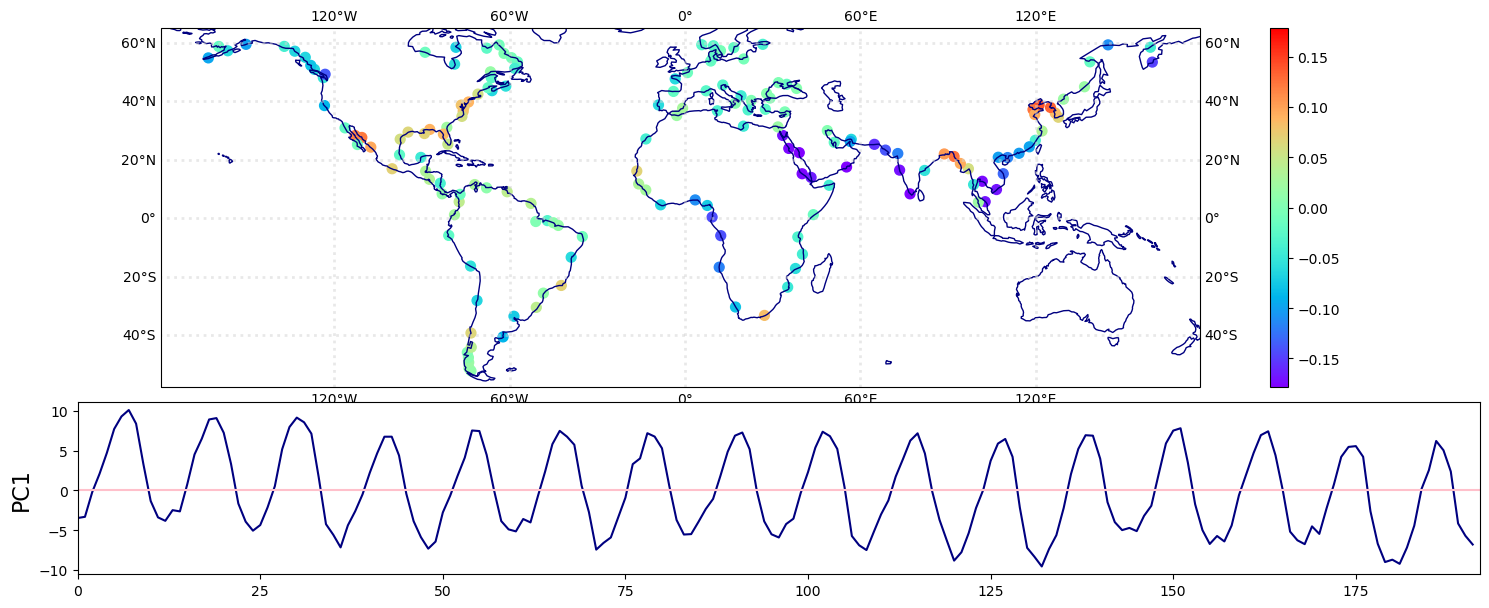

In [22]:
pc_plot = 1

fig = plt.figure(figsize = [15, 6], tight_layout=True)
gs = gridspec.GridSpec(3, 1)
ax = fig.add_subplot(gs[:2,0], projection=ccrs.PlateCarree() )

ax.coastlines(zorder=2, color = 'navy');
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='lightgrey', linestyle=':',  alpha=.5)

lim = np.max([np.abs(np.min(xds_PCA.isel(n_components = pc_plot).EOFs.values)), np.max(xds_PCA.isel(n_components = pc_plot).EOFs.values)])

im = ax.scatter(lon, lat, s=50, c = xds_PCA.isel(n_components = pc_plot).EOFs.values,
                transform = ccrs.PlateCarree(), vmin=-lim, vmax= lim, cmap = 'rainbow')

plt.colorbar(im, ax=ax)


ax1 = fig.add_subplot(gs[2,0])
ax1.plot(xds_PCA.isel(n_components = pc_plot).PCs.values, color = 'navy')
ax1.plot([0, len(xds_PCA.time)], [0,0], color = 'pink')
ax1.set_xlim([0, len(xds_PCA.time)])
ax1.set_ylabel('PC{0}'.format(pc_plot), fontsize = 16)


(0.0, 192.0)

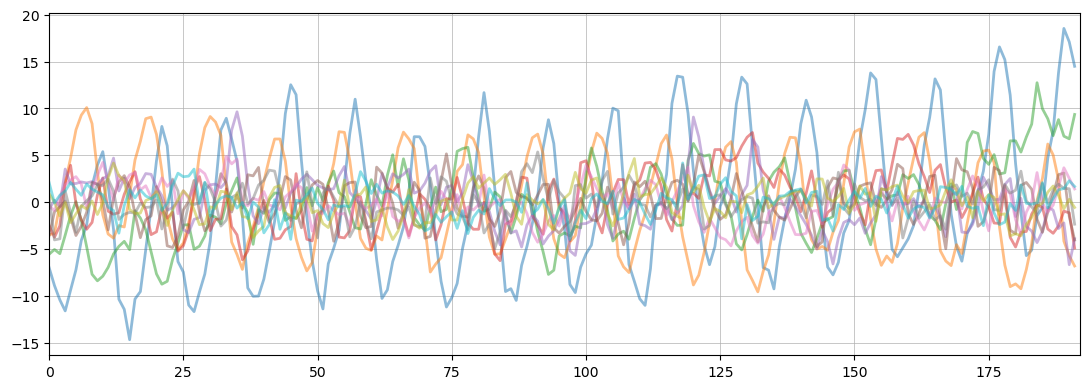

In [23]:
n_pcs_plot = 10

fig = plt.figure(figsize = [11, 4], tight_layout=True)
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
ax.grid(linewidth = .5)

for p in range(n_pcs_plot):

    ax.plot(xds_PCA.isel(n_components = p).PCs.values, label = 'PC{0}'.format(p), linewidth = 2, alpha=.5)
    
#plt.legend(ncol = n_pcs_plot, fontsize = 15)
ax.set_xlim([0, len(xds_PCA.isel(n_components = p).PCs.values)])


### Reconstruction

- First we select the ones explaining the % of the variance defined above

In [24]:
xds_PCA = xds_PCA.isel(n_components = range(n_pcs))

- Then we can reconstruct the spatial field back from the PCs and the EOFs at each instant

$$X(x, t) = EOF_1 (x) * PC_1 (t) + EOF_2 (x) * PC_2 (t) + ... + EOF_n (x) * PC_n (t) $$

In [25]:
sla_reconstructed = (xds_PCA.PCs*(xds_PCA.EOFs)).sum(dim='n_components') * xds_PCA.stds + xds_PCA.means

In [26]:
time =5

sla_recon_time = sla_reconstructed.isel(time=time)
sla_real_time = sla[:,time]

- Real vs reconstructed

Text(0.5, 1.0, 'Reconstructed - Real')

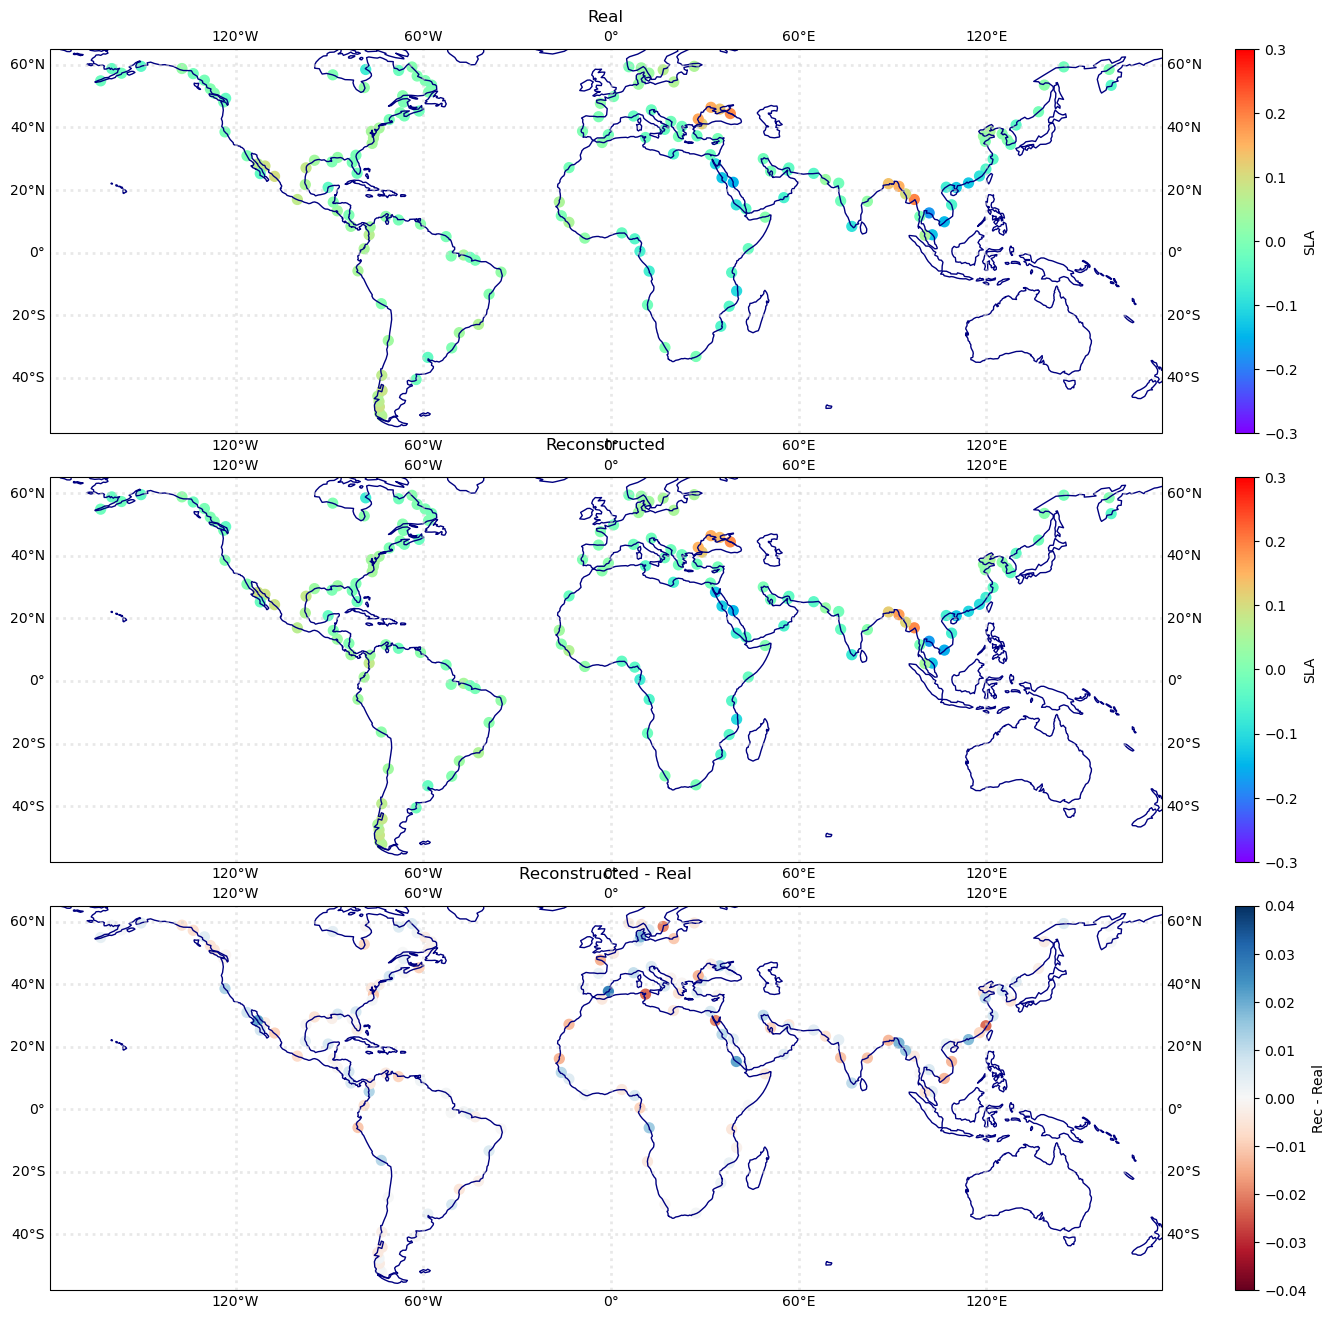

In [27]:
# Real plot

fig = plt.figure(figsize = [15, 13], tight_layout=True)
gs = gridspec.GridSpec(3, 1)

#Real
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree() )
ax.coastlines(zorder=2, color = 'navy');
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='lightgrey', linestyle=':',  alpha=.5)

im = ax.scatter(lon, lat, s=50, c = sla_real_time , vmin=-.3, vmax=.3, transform = ccrs.PlateCarree(), cmap = 'rainbow')

plt.colorbar(im, ax=ax).set_label('SLA')
ax.set_title('Real')

#Reconstructed
ax1 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree() )
ax1.coastlines(zorder=2, color = 'navy');
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='lightgrey', linestyle=':',  alpha=.5)

im = ax1.scatter(lon, lat, s=50, c = sla_recon_time , vmin=-.3, vmax=.3, transform = ccrs.PlateCarree(), cmap = 'rainbow')

plt.colorbar(im, ax=ax1).set_label('SLA')
ax1.set_title('Reconstructed')


#Differences
ax2 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree() )
ax2.coastlines(zorder=2, color = 'navy');
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='lightgrey', linestyle=':',  alpha=.5)

im = ax2.scatter(lon, lat, s=50, c = sla_recon_time - sla_real_time , vmin=-.04, vmax=.04, transform = ccrs.PlateCarree(), cmap = 'RdBu')

plt.colorbar(im, ax=ax2).set_label('Rec - Real')
ax2.set_title('Reconstructed - Real')

